In [1]:
import numpy as np
import tensorflow as tf

import pandas as pd
from scipy.stats import norm
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras import regularizers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras import backend as K
from keras import metrics
from keras.datasets import mnist
from nn_models import *
import pickle

import plotly.plotly as py
import plotly.graph_objs as go
import plotly
import colorlover as cl
from IPython.display import HTML

from utils import *
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
__date__ = '2017-08-04'

Using TensorFlow backend.


In [2]:
window_size = 6
filter_length=3
nb_filter=128
batch_size = 20
data_ = make_clean_data(window_size, batch_size,multiplier=1)

time_percentage=0.9
time_spent = data_['dataset'].sum(axis=0)/data_['dataset'].sum()*100

print("Dataset size:", data_['yc'].shape,'\n')
print("Number of apps that consume", time_percentage*100, "% of all users time: ",len(data_['popular_apps']), '\n')

graphdata = [go.Bar(
            x=data_['popular_apps'],
            y=time_spent,
            marker=dict(
        color= data_['data_colors']),
    )]

py.iplot(graphdata, filename='basic-bar')

/home/asturkmani/Thesis/utils.py:253: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



Dataset size: (18280, 15) 

Number of apps that consume 90.0 % of all users time:  15 



# VAE

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
Input (InputLayer)               (None, 15)            0                                            
____________________________________________________________________________________________________
Encoder_H (Dense)                (None, 10)            160         Input[0][0]                      
____________________________________________________________________________________________________
mu (Dense)                       (None, 2)             22          Encoder_H[0][0]                  
____________________________________________________________________________________________________
l_sigma (Dense)                  (None, 2)             22          Encoder_H[0][0]                  
___________________________________________________________________________________________

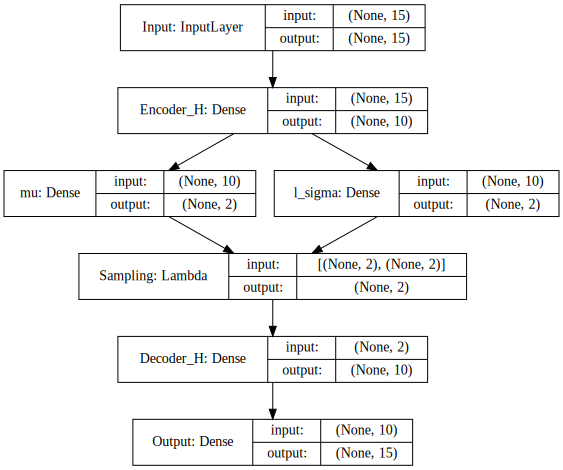

In [3]:
original_dim = data_['x_train_c'].shape[-1]

time_dim = data_['time']
days_dim = data_['days']
latent_dim = 2
intermediate_dim = 10
epochs = 100
batch_size = 20

vae, encoder, generator = build_vae(original_dim,
              batch_size = 20,
              latent_dim = 2,
              intermediate_dim = 10,
              activ='relu',
              optim=Adam(lr=0.0005),
              epsilon_std=1.)
print(vae.summary())
SVG(model_to_dot(vae, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

In [5]:
vae_hist = vae.fit(data_['y_train_c'], 
                   data_['y_train_c'],
                   verbose = 0,
                   shuffle=False,
                   batch_size=batch_size,
                   epochs=epochs,
                   validation_data = (
                       data_['y_test_c'],
                       data_['y_test_c']),
                   callbacks = [
                       EarlyStopping(patience = 5),
                       TQDMNotebookCallback(metric_format="{name}: {value:0.4f}",
                                                              leave_outer=True,
                                                              leave_inner=True)]
                  )
z_train = encoder.predict(data_['yc'])
encodings= np.asarray(z_train)
encodings = encodings.reshape(data_['yc'].shape[0], latent_dim)
print(encodings.shape)


(18280, 2)


In [6]:
x = encodings[:,0]
y = encodings[:,1]
t = ['<br>'.join(json.dumps(x).split(',')) for x in data_['y_labels']]

trace1 = go.Scatter(
    x=x,
    y=y, 
    mode='markers',
    marker=dict(color = data_['yc_colors'], opacity=0.8),
    text = t
)
data = [trace1]
layout = go.Layout(margin=dict(l=0,r=0,b=0,t=0))
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='VAE-Data')

# plt.figure(figsize=(7, 7))
# plt.scatter(encodings[:, 0], encodings[:, 1], c=data_['yc_colors'])
# plt.show()

# VAE with Time & Day

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
Input (InputLayer)               (None, 15)            0                                            
____________________________________________________________________________________________________
Day (InputLayer)                 (None, 7)             0                                            
____________________________________________________________________________________________________
Time (InputLayer)                (None, 24)            0                                            
____________________________________________________________________________________________________
concatenate_3 (Concatenate)      (None, 46)            0           Input[0][0]                      
                                                                   Day[0][0]               

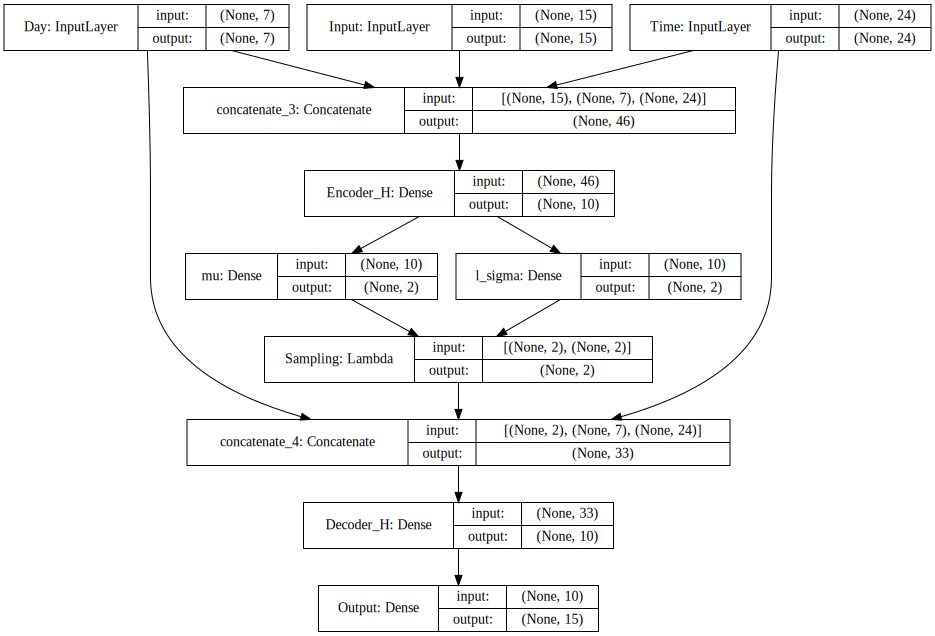

In [12]:
c_vae, c_encoder, c_generator =  buid_cvae(original_dim,
              batch_size = 20,
              latent_dim = 2,
              intermediate_dim = 10,
              activ='relu',
              optim=Adam(lr=0.0005),
              epsilon_std=1.,
              time_dim=24,
              day_dim=7)
print(c_vae.summary())
SVG(model_to_dot(c_vae, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

In [13]:
# compile and fit
c_vae_hist = c_vae.fit([data_['y_train_c'], to_categorical(data_['y_train_d']), to_categorical(data_['y_train_t'])], 
                            data_['y_train_c'], 
                            verbose = 0, 
                            shuffle=False,
                            batch_size=batch_size, 
                            epochs=epochs,
                            validation_data = (
                                [data_['y_test_c'], to_categorical(data_['y_test_d']),to_categorical(data_['y_test_t'])], 
                                data_['y_test_c']),
                            callbacks = [EarlyStopping(patience = 5),
                                         TQDMNotebookCallback(metric_format="{name}: {value:0.4f}",
                                                              leave_outer=True,
                                                              leave_inner=True)])

In [14]:
z_train = c_encoder.predict([data_['yc'], to_categorical(data_['yd']), to_categorical(data_['yt'])])
c_encoding = np.asarray(z_train)
print(c_encoding.shape)

x = c_encoding[:,0]
y = c_encoding[:,1]
t = ['<br>'.join(json.dumps(x).split(',')) for x in data_['y_labels']]

trace1 = go.Scatter(
    x=x,
    y=y, 
    mode='markers',
    marker=dict(color = data_['yc_colors'], opacity=0.8),
    text = t
)
data = [trace1]
layout = go.Layout(margin=dict(l=0,r=0,b=0,t=0))
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='C_d_VAE-Data')

# plt.figure(figsize=(7, 7))
# plt.scatter(encodings[:, 0], encodings[:, 1], c=data_['yc_colors'])
# plt.show()

(18280, 2)


# LSTM VAE

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
Input (InputLayer)               (None, 6, 15)         0                                            
____________________________________________________________________________________________________
LSTM_Encoder (LSTM)              (None, 32)            6144        Input[0][0]                      
____________________________________________________________________________________________________
Z_Mean (Dense)                   (None, 2)             66          LSTM_Encoder[0][0]               
____________________________________________________________________________________________________
Z_log_sigma (Dense)              (None, 2)             66          LSTM_Encoder[0][0]               
___________________________________________________________________________________________

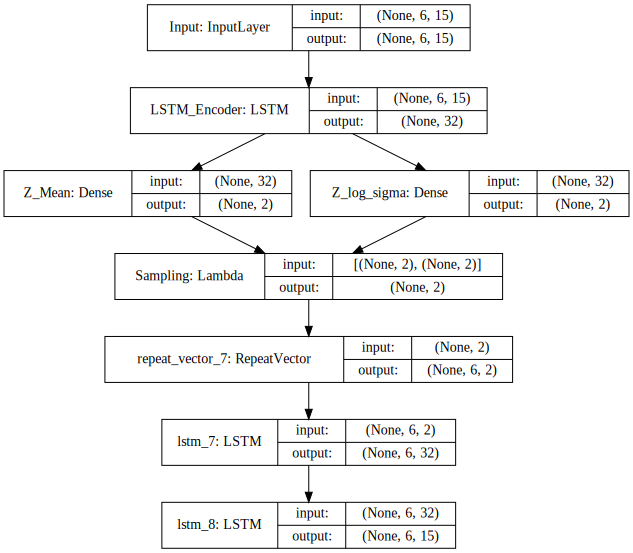

In [24]:
original_dim = data_['x_train_c'].shape[-1] # 13
timesteps = data_['x_train_c'].shape[1] # 3
# time_dim = data_['time']
# day_dim = data_['days']

batch_size = 50
latent_dim = 2
intermediate_dim = 32
        
lstm_vae, lstm_encoder, lstm_generator= build_lstm_c_vae(original_dim,
                                       timesteps,
                                       batch_size,
                                       latent_dim,
                                       intermediate_dim,
                                       activ='relu',
                                       optim=Adam(lr=0.005),
                                       epsilon_std=1.,
                                       time_dim=0,
                                       day_dim=0)

print(lstm_vae.summary())
SVG(model_to_dot(lstm_vae, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

In [25]:
data_['x_test_c'].shape

(3640, 6, 15)

In [26]:
lstm_vae_hist = lstm_vae.fit(data_['x_train_c'], 
                   data_['x_train_c'],
                   verbose = 0,
                   shuffle=False,
                   batch_size=batch_size,
                   epochs=100,
                   validation_data = (
                       data_['x_test_c'],
                       data_['x_test_c']),
                   callbacks = [
                       EarlyStopping(patience = 5),
                       TQDMNotebookCallback(metric_format="{name}: {value:0.4f}",leave_outer=True,leave_inner=True),
                       ReduceLROnPlateau(monitor='val_loss', factor=0.1,patience=2, min_lr=0.000001, verbose=0)]
                  )

2700/|/[loss: 0.1399, KL_loss: 0.0022, recon_loss: 0.1377]  18%|| 2700/14620 [00:22<00:09, 1253.35it/s]

In [27]:
z_train = lstm_encoder.predict(data_['Xc'])
encodings= np.asarray(z_train)
encodings = encodings.reshape(data_['Xc'].shape[0], latent_dim)
print(encodings.shape)
new_l = len(encodings)-1
encodings_shifted = encodings[-new_l:]

colors_shifted = data_['yc_colors'][:new_l]

x = encodings_shifted[:,0]
y = encodings_shifted[:,1]
t = ['<br>'.join(json.dumps(x).split(',')) for x in data_['y_labels']]

trace1 = go.Scatter(
    x=x,
    y=y, 
    mode='markers',
    marker=dict(color = colors_shifted, opacity=0.8),
    text = t
)
data = [trace1]
layout = go.Layout(margin=dict(l=0,r=0,b=0,t=0))
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='VAE-LSTM-Data')

(18280, 2)


# LSTM VAE with Time & Day

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
Input (InputLayer)               (None, 6, 15)         0                                            
____________________________________________________________________________________________________
Day (InputLayer)                 (None, 6, 7)          0                                            
____________________________________________________________________________________________________
Time (InputLayer)                (None, 6, 24)         0                                            
____________________________________________________________________________________________________
concatenate_5 (Concatenate)      (None, 6, 46)         0           Input[0][0]                      
                                                                   Day[0][0]               

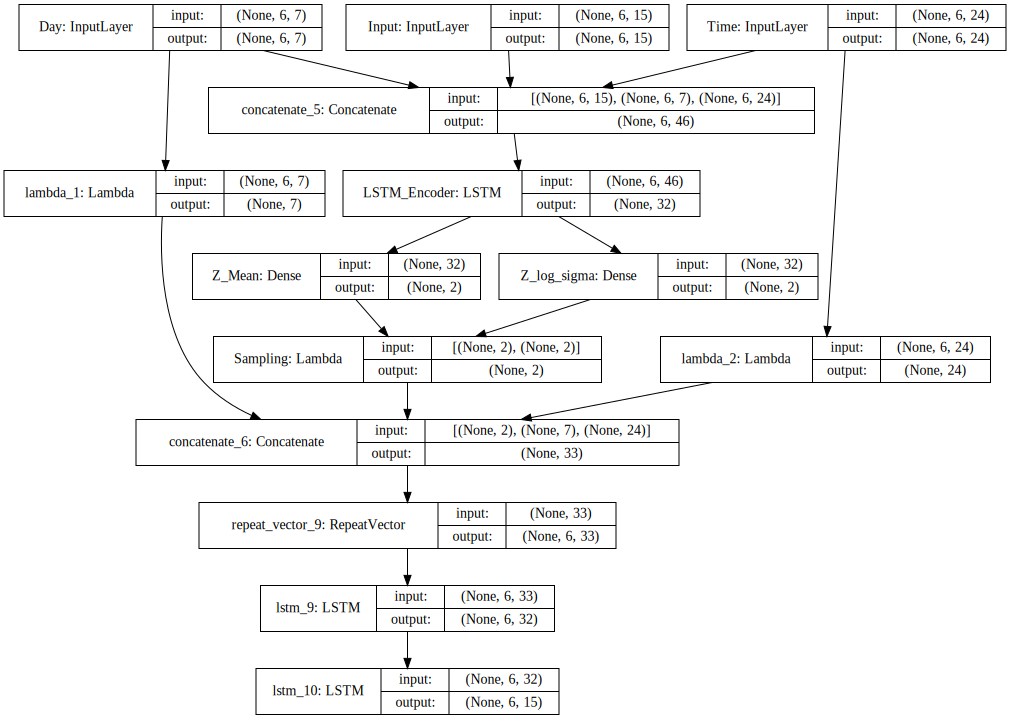

In [30]:
original_dim = data_['x_train_c'].shape[-1] # 13
timesteps = data_['x_train_c'].shape[1] # 3
# time_dim = data_['time']
# day_dim = data_['days']

batch_size = 50
latent_dim = 2
intermediate_dim = 32
        
c_lstm_vae, c_lstm_encoder, c_lstm_generator= build_lstm_c_vae(original_dim,
                                       timesteps,
                                       batch_size,
                                       latent_dim,
                                       intermediate_dim,
                                       activ='relu',
                                       optim=Adam(lr=0.005),
                                       epsilon_std=1.,
                                       time_dim=24,
                                       day_dim=7)

print(c_lstm_vae.summary())
SVG(model_to_dot(c_lstm_vae, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

In [29]:
x_d = np.asarray([to_categorical(x, num_classes=data_['days']) for x in data_['Xd']])
x_t = np.asarray([to_categorical(x, num_classes=data_['time']) for x in data_['Xt']])

x_train_d = np.asarray([to_categorical(x, num_classes=data_['days']) for x in data_['x_train_d']])
x_train_t = np.asarray([to_categorical(x, num_classes=data_['time']) for x in data_['x_train_t']])

x_test_d = np.asarray([to_categorical(x, num_classes=data_['days']) for x in data_['x_test_d']])
x_test_t = np.asarray([to_categorical(x, num_classes=data_['time']) for x in data_['x_test_t']])

# compile and fit
c_lstm_vae_hist = c_lstm_vae.fit(
    [data_['x_train_c'], x_train_d, x_train_t], 
    data_['x_train_c'], 
    verbose = 0, 
    batch_size=batch_size, 
    epochs=100,
    validation_data = ([data_['x_test_c'], x_test_d,x_test_t], 
                        data_['x_test_c']),
    callbacks = [EarlyStopping(patience = 5),TQDMNotebookCallback(metric_format="{name}: {value:0.4f}"),ReduceLROnPlateau(monitor='val_loss', factor=0.1,patience=2, min_lr=0.000001, verbose=0)])

In [31]:
z_train = c_lstm_encoder.predict([data_['Xc'], x_d, x_t])
c_lstm_encodings= np.asarray(z_train)
c_lstm_encodings = c_lstm_encodings.reshape(data_['Xc'].shape[0], latent_dim)
print(c_lstm_encodings.shape)
new_l = len(c_lstm_encodings)-1
c_lstm_encodings_shifted = c_lstm_encodings[-new_l:]

colors_shifted = data_['yc_colors'][:new_l]

x = c_lstm_encodings_shifted[:,0]
y = c_lstm_encodings_shifted[:,1]
t = ['<br>'.join(json.dumps(x).split(',')) for x in data_['y_labels']]

trace1 = go.Scatter(
    x=x,
    y=y, 
    mode='markers',
    marker=dict(color = colors_shifted, opacity=0.8),
    text = t
)
data = [trace1]
layout = go.Layout(margin=dict(l=0,r=0,b=0,t=0))
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='VAE-LSTM-Data')

(18280, 2)


# Conv1D / LSTM for Time Series Prediction

Here we examine first using a conv1d/lstm to make time-series regression on the next 5-minute block and visualize hidden states in the latent space

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 6, 15)             0         
_________________________________________________________________
Conv1 (Conv1D)               (None, 4, 64)             2944      
_________________________________________________________________
Flatten (Flatten)            (None, 256)               0         
_________________________________________________________________
Dense_Out2 (Dense)           (None, 15)                3855      
Total params: 6,799
Trainable params: 6,799
Non-trainable params: 0
_________________________________________________________________
None


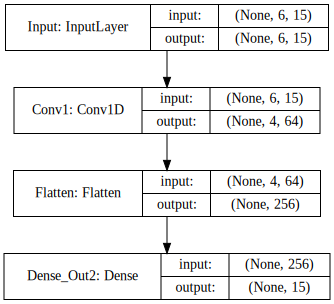

In [32]:
window_size=6
filter_length=3
original_dim = data_['x_train_c'].shape[-1]
nb_input_series=original_dim
nb_outputs=original_dim
nb_filter=64

inputs = Input(shape=(window_size, original_dim), name='Input')
conv1 = Conv1D(name='Conv1', 
               filters=nb_filter, 
               kernel_size=filter_length, 
               activation='elu', 
               input_shape=(window_size, nb_input_series)
              )(inputs)

flat1 = Flatten(name='Flatten')(conv1)
output = Dense(nb_outputs, activation='relu',name='Dense_Out2')(flat1)     # For binary classification, change the activation to 'sigmoid'
 
conv_encoder = Model(inputs,flat1)
conv_model = Model(inputs,output)
conv_model.compile(loss='mse', optimizer='adam', metrics=['mae'])
print(conv_model.summary())
# To perform (binary) classification instead:
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])
SVG(model_to_dot(conv_model, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

In [33]:
early_stop = EarlyStopping(monitor='val_loss', patience=5)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,patience=2, min_lr=0.000001, verbose=0)
conv_model_data = conv_model.fit(
    data_['x_train_c'], 
    data_['y_train_c'], 
    verbose=0, 
    epochs=1000, 
    batch_size=128, 
    validation_data=(data_['x_test_c'], data_['y_test_c']), 
    callbacks=[reduce_lr,early_stop, TQDMNotebookCallback(metric_format="{name}: {value:0.4f}")])

In [34]:
y_pred = conv_model.predict(data_['x_test_c'], batch_size=20)
Y_test = data_['y_test_c']
for i in range(0,Y_test.shape[0],10):
    print("=== Prediction ===", "\n")
    print(np.round(y_pred[i]*300), "\n")
    print("=== True value ===","\n")
    print(np.round(Y_test[i]*300), "\n")

=== Prediction === 

[ 108.    0.    0.   20.    0.    0.   97.    0.    0.    4.    7.    0.
    0.    0.    7.] 

=== True value === 

[  85.    0.    0.    0.    0.    0.  211.    0.    0.    0.    0.    0.
    0.    0.    4.] 

=== Prediction === 

[ 25.   6.   0.  16.   1.   7.   2.   7.   3.   0.   1.   0.   0.   0.   9.] 

=== True value === 

[ 39.   0.   0.   0.   0.   0.   0.   0.   6.   0.   0.   0.   0.   0.  27.] 

=== Prediction === 

[ 18.   0.   2.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  27.] 

=== True value === 

[  77.    0.  122.    0.   27.    0.    0.    1.    0.    0.    0.    0.
    0.    0.    0.] 

=== Prediction === 

[   6.    0.  216.    0.   11.    0.    0.    0.    0.    0.    0.   34.
    0.    0.    7.] 

=== True value === 

[   0.    0.  279.    0.    0.    0.    0.    0.   21.    0.    0.    0.
    0.    0.    0.] 

=== Prediction === 

[   0.    9.  193.    3.    0.    0.    0.    0.    0.    0.    0.   49.
    0.    0.   23.] 

=== 

[ 31.   0.  22.  19.  12.   0.   0.  48.   0.   0.   0.   0.   0.   0.  59.] 

=== True value === 

[   0.    0.  226.    0.    0.    6.    0.    4.   19.    0.    0.    0.
    0.    0.   11.] 

=== Prediction === 

[ 25.   5.   0.  16.   0.   6.   2.   8.   3.   0.   0.   0.   0.   0.  10.] 

=== True value === 

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  2.] 

=== Prediction === 

[  16.    0.    0.   11.    0.    0.    0.  129.    0.   43.    9.    0.
    0.    0.   19.] 

=== True value === 

[   0.    0.    0.    0.    0.   38.  174.    0.   14.   18.    0.    0.
    0.    0.   13.] 

=== Prediction === 

[   0.    0.  240.   17.    7.    0.    0.    0.    0.    0.    0.   40.
    0.    0.   17.] 

=== True value === 

[   0.    0.  294.    0.    0.    0.    0.    0.    0.    0.    0.    6.
    0.    0.    0.] 

=== Prediction === 

[ 25.   6.   0.  16.   1.   7.   2.   7.   3.   0.   1.   0.   0.   0.   9.] 

=== True value === 

[ 223.    0.    0.   36.    0.    0

[ 36.   9.  22.   5.   0.   0.   0.  24.  11.   8.   5.   0.   0.   0.   9.] 

=== True value === 

[  0.   0.   1.   0.   0.   8.   0.  13.  20.   0.  15.   0.  93.   0.   1.] 

=== Prediction === 

[   1.    0.   71.    0.    6.    0.    0.    0.   11.    0.    0.    0.
  175.    0.    8.] 

=== True value === 

[   0.    0.  225.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   75.    0.    0.] 

=== Prediction === 

[   0.    0.  184.    2.    0.    0.    0.    0.   13.    0.    0.   26.
    0.    0.    6.] 

=== True value === 

[   0.    0.  206.    0.    0.    0.    0.    0.   51.    0.    0.    0.
   42.    0.    1.] 

=== Prediction === 

[   1.    2.   92.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  169.    0.   10.] 

=== True value === 

[   0.    0.   94.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  196.    0.    0.] 

=== Prediction === 

[ 29.   0.   0.  10.   9.   6.   0.   8.  18.  12.   0.   9.   0.   0.  12.] 

=== True value === 

[ 48


[   0.    0.   82.    0.    0.   13.    0.    0.    2.    0.  154.    0.
    0.    0.    4.] 

=== Prediction === 

[ 23.   9.   8.   3.   4.  13.   2.   1.   7.   0.   4.   2.   0.   0.   9.] 

=== True value === 

[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  92.   0.   1.] 

=== Prediction === 

[  61.    0.   18.    0.    0.    0.    0.    0.    0.    0.    9.    0.
  118.    0.   38.] 

=== True value === 

[   2.    0.   16.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  270.    0.   12.] 

=== Prediction === 

[  0.   0.  46.   0.   0.   0.   0.  13.   0.   0.   0.   0.  87.   0.  32.] 

=== True value === 

[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.  19.   0.   0.] 

=== Prediction === 

[  14.    0.  209.    0.   10.    0.    0.    0.    0.    0.    0.    0.
    1.    0.   19.] 

=== True value === 

[   0.    0.  149.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  151.    0.    0.] 

=== Prediction === 

[  7.  21.  75.   5

# Comparing latent space of Prediction vs True Value

In [37]:
y_pred_z = vae.predict(y_pred, batch_size=20)
y_true_z = vae.predict(Y_test, batch_size=20)
print(y_pred_z.shape, y_true_z.shape)

# plt.figure(figsize=(7, 7))
# plt.scatter(encodings[:, 0], encodings[:, 1], c=data_['yc_colors'])
# plt.show()

(3640, 15) (3640, 15)


In [39]:
y_pred_colors = convert_to_rgb(np.einsum('ij,jk->ik', y_pred, data_['cmap']))
x = y_pred_z[:,0]
y = y_pred_z[:,1]
t = ['<br>'.join(json.dumps(x).split(',')) for x in data_['y_test_labels']]

trace1 = go.Scatter(
    x=x,
    y=y, 
    mode='markers',
    marker=dict(color = y_pred_colors, opacity=0.8),
    text = t
)
data = [trace1]
layout = go.Layout(margin=dict(l=0,r=0,b=0,t=0))
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='VAE-Data')

In [40]:
x = y_true_z[:,0]
y = y_true_z[:,1]
t = ['<br>'.join(json.dumps(x).split(',')) for x in data_['y_test_labels']]

trace1 = go.Scatter(
    x=x,
    y=y, 
    mode='markers',
    marker=dict(color = data_['y_test_c_colors'], opacity=0.8),
    text = t
)
data = [trace1]
layout = go.Layout(margin=dict(l=0,r=0,b=0,t=0))
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='VAE-Data')

In [41]:
x_train_encoded_conv = conv_encoder.predict(data_['x_train_c'])
x_test_encoded_conv = conv_encoder.predict(data_['x_test_c'])
print(x_train_encoded_conv.shape)
print(x_test_encoded_conv.shape)
x_encoded = np.concatenate((x_train_encoded_conv,x_test_encoded_conv),axis=0)
print(x_encoded.shape)

(14620, 256)
(3640, 256)
(18260, 256)


## VAE on Conv1D hidden state

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
Input (InputLayer)               (None, 256)           0                                            
____________________________________________________________________________________________________
Encoder_H (Dense)                (None, 64)            16448       Input[0][0]                      
____________________________________________________________________________________________________
Encoder_H2 (Dense)               (None, 32)            2080        Encoder_H[0][0]                  
____________________________________________________________________________________________________
mu (Dense)                       (None, 2)             66          Encoder_H2[0][0]                 
___________________________________________________________________________________________

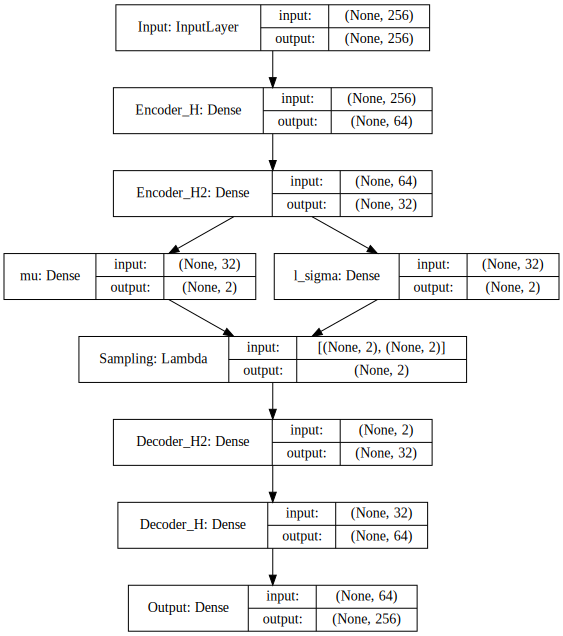

In [42]:
original_dim = data_['x_train_c'].shape[-1]

time_dim = data_['time']
days_dim = data_['days']
latent_dim = 2
intermediate_dim = 10
epochs = 100
batch_size = 20

conv_vae, conv_vae_encoder, conv_vae_generator = buid_cvae(x_encoded.shape[1],
              batch_size = 20,
              latent_dim = 2,
              intermediate_dim = 64,
              intermediate_dim2 = 32,
              activ='relu',
              optim=Adam(lr=0.0005),
              epsilon_std=1.)
print(conv_vae.summary())
SVG(model_to_dot(conv_vae, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

In [43]:
early_stop = EarlyStopping(monitor='val_loss', patience=5)

conv_vae.fit(x_train_encoded_conv,
             x_train_encoded_conv,
            shuffle=True,
            epochs=epochs,
             verbose=0,
            batch_size=batch_size,
            validation_data=(x_test_encoded_conv,x_test_encoded_conv),
           callbacks=[early_stop,TQDMNotebookCallback(metric_format="{name}: {value:0.4f}")])

In [44]:
# display a 2D plot of the digit classes in the latent space
conv_vae_encoded = conv_vae_encoder.predict(x_encoded, batch_size=batch_size)


x = conv_vae_encoded[:,0]
y = conv_vae_encoded[:,1]
t = ['<br>'.join(json.dumps(x).split(',')) for x in data_['y_labels']]

trace1 = go.Scatter(
    x=x,
    y=y, 
    mode='markers',
    marker=dict(color = data_['yc_colors'], opacity=0.8),
    text = t
)
data = [trace1]
layout = go.Layout(margin=dict(l=0,r=0,b=0,t=0))
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='VAE-Conv-Data')

# Analysis
Here it is important to remember that the encoded representation is the summary of the previous window of activity and the label is the next time step
    1. Clusters of the same color therefore signify apps that tend to be used consistently and focused on for extended periods of time
    2. There seem to be 6 gaussians in this latent space signifying this latent distribution is in fact a mixture of Gaussians. Since this latent space is a generative one, we can infer that there exist 6 main modes of app-usage behaviour. Below we visualize the Gaussian Mixtures

In [47]:
nk=6
kmeans = KMeans(n_clusters=nk).fit(conv_vae_encoded)
gmm_scaled = GaussianMixture(n_components = nk, covariance_type='tied')
gmm_scaled.fit(conv_vae_encoded)
gmm_scaled_labels = gmm_scaled.predict(conv_vae_encoded)

In [48]:
x = conv_vae_encoded[:,0]
y = conv_vae_encoded[:,1]
t = ['<br>'.join(json.dumps(x).split(',')) for x in data_['y_labels']]
bupu = cl.scales[str(nk)]['div']['RdBu']
c = [bupu[x] for x in kmeans.labels_]
trace1 = go.Scatter(
    x=x,
    y=y, 
    mode='markers',
    marker=dict(color = c, opacity=0.8),
    text = t
)
data = [trace1]
layout = go.Layout(margin=dict(l=0,r=0,b=0,t=0))
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='VAE-Conv-Data-GMM')

### Time & Day VAE on Conv1D hidden state

In [49]:
original_dim = data_['x_train_c'].shape[-1]

time_dim = data_['time']
days_dim = data_['days']
latent_dim = 2
intermediate_dim = 10
epochs = 100
batch_size = 20

conv_vae_td, conv_vae_encoder_td, conv_vae_generator_td = buid_cvae(
    x_encoded.shape[1],
    batch_size = 20,
    latent_dim = 2,
    intermediate_dim = 64,
    intermediate_dim2 = 32,
    activ='relu',
    optim=Adam(lr=0.0005),
    epsilon_std=1.,
    time_dim=time_dim,
    day_dim=days_dim)

In [50]:
# compile and fit
conv_vae_td_hist = conv_vae_td.fit([x_train_encoded_conv, to_categorical(data_['y_train_d']), to_categorical(data_['y_train_t'])], 
                            x_train_encoded_conv, 
                            verbose = 0, 
                            shuffle=False,
                            batch_size=batch_size, 
                            epochs=epochs,
                            validation_data = (
                                [x_test_encoded_conv, to_categorical(data_['y_test_d']),to_categorical(data_['y_test_t'])], 
                                x_test_encoded_conv),
                            callbacks = [EarlyStopping(patience = 5),
                                         TQDMNotebookCallback(metric_format="{name}: {value:0.4f}")])


In [51]:
# display a 2D plot of the digit classes in the latent space
conv_vae_encoded_td = conv_vae_encoder_td.predict([x_encoded, to_categorical(data_['yd']), to_categorical(data_['yt'])], batch_size=batch_size)


x = conv_vae_encoded_td[:,0]
y = conv_vae_encoded_td[:,1]
t = ['<br>'.join(json.dumps(x).split(',')) for x in data_['y_labels']]

trace1 = go.Scatter(
    x=x,
    y=y, 
    mode='markers',
    marker=dict(color = data_['yc_colors'], opacity=0.8),
    text = t
)
data = [trace1]
layout = go.Layout(margin=dict(l=0,r=0,b=0,t=0))
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='VAE-Conv-Data')

# LSTM, VAE, VAE_TD

In [69]:
inputs = Input(shape=(window_size, original_dim), name='Inputs')
# inputs_masked = Masking(mask_value=0., name='Masking')(inputs)
encoded = LSTM(64, name='LSTM', activation='elu')(inputs)
output = Dense(original_dim, activation='linear')(encoded)

rnn_encoder = Model(inputs, encoded)
rnn_model = Model(inputs, output)

rnn_model.compile(loss='mse', metrics=['mae'], optimizer='rmsprop')
print(rnn_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Inputs (InputLayer)          (None, 6, 15)             0         
_________________________________________________________________
LSTM (LSTM)                  (None, 64)                20480     
_________________________________________________________________
dense_5 (Dense)              (None, 15)                975       
Total params: 21,455
Trainable params: 21,455
Non-trainable params: 0
_________________________________________________________________
None


In [73]:
early_stop = EarlyStopping(monitor='val_loss', patience=5)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,patience=2, min_lr=0.000001, verbose=0)
rnn_model_hist= rnn_model.fit(
    data_['x_train_c'], 
    data_['y_train_c'], 
    verbose=0, 
    epochs=1000, 
    batch_size=128, 
    validation_data=(data_['x_test_c'], data_['y_test_c']), 
    callbacks=[reduce_lr,
               early_stop,
               TQDMNotebookCallback(metric_format="{name}: {value:0.4f}",leave_outer=True,leave_inner=True)])

In [71]:
y_pred = rnn_model.predict(data_['x_test_c'], batch_size=20)
Y_test = data_['y_test_c']
for i in range(0,Y_test.shape[0],10):
    print("=== Prediction ===", "\n")
    print(np.round(y_pred[i]*300), "\n")
    print("=== True value ===","\n")
    print(np.round(Y_test[i]*300), "\n")

=== Prediction === 

[ 102.   11.    2.   17.    8.    0.   94.    3.    0.    5.    7.    1.
    3.    2.    4.] 

=== True value === 

[  85.    0.    0.    0.    0.    0.  211.    0.    0.    0.    0.    0.
    0.    0.    4.] 

=== Prediction === 

[ 27.   4.  -0.  14.   3.   7.   2.   7.   4.   1.   2.   2.   1.   1.   8.] 

=== True value === 

[ 39.   0.   0.   0.   0.   0.   0.   0.   6.   0.   0.   0.   0.   0.  27.] 

=== Prediction === 

[ 26.   9.   2.  13.  17.   2.   3.   5.   4.   1.   0.   2.   1.  -0.  20.] 

=== True value === 

[  77.    0.  122.    0.   27.    0.    0.    1.    0.    0.    0.    0.
    0.    0.    0.] 

=== Prediction === 

[   7.    7.  198.    9.    6.   -2.    9.    4.   17.    6.   -0.   16.
    2.   -1.   16.] 

=== True value === 

[   0.    0.  279.    0.    0.    0.    0.    0.   21.    0.    0.    0.
    0.    0.    0.] 

=== Prediction === 

[   2.    9.  154.   11.   12.   -3.    4.    2.   40.    6.   -1.   39.
   -0.   -1.   17.] 

=== 

=== True value === 

[ 43.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   2.] 

=== Prediction === 

[ 81.   4.   2.  15.   5.   6.   3.   8.  15.   2.   4.   0.   1.   0.   4.] 

=== True value === 

[ 222.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.] 

=== Prediction === 

[  31.    3.   -1.  148.   -0.    5.    1.    3.    8.    3.    3.    1.
   -0.   -1.    3.] 

=== True value === 

[ 202.    0.    0.    0.    0.    0.    0.    0.   12.   86.    0.    0.
    0.    0.    0.] 

=== Prediction === 

[  15.   17.    6.    7.    0.    5.   28.  147.    4.   15.    8.    5.
   21.    1.    7.] 

=== True value === 

[   0.    0.    0.    0.    0.    0.    0.  299.    0.    0.    0.    0.
    0.    0.    1.] 

=== Prediction === 

[ 18.   4.   0.  51.   5.  29.  38.   5.  11.   3.   2.   2.   1.   1.  12.] 

=== True value === 

[   0.    0.    0.    0.    0.    0.  178.    0.    4.    0.    0.    0.
    0.    0.  118.] 

=== 

   55.   -5.   10.] 

=== True value === 

[   0.    0.  204.    0.    0.    0.    0.    0.    5.    0.    0.    0.
   84.    0.    6.] 

=== Prediction === 

[  14.    8.  169.    9.    7.   -2.    5.    6.    6.    5.    2.   11.
   42.   -2.   19.] 

=== True value === 

[   1.    0.  168.    0.    0.    0.    0.    0.    1.    0.    0.    0.
    0.    0.    8.] 

=== Prediction === 

[ 28.   4.  -0.  14.   3.   6.   2.   8.   4.   1.   2.   1.   0.   1.   8.] 

=== True value === 

[ 45.   0.  10.   0.   0.   2.   0.  54.   0.   0.   0.   6.   0.   0.   2.] 

=== Prediction === 

[  21.    2.    2.   20.    2.   10.    5.    9.    3.    8.  159.    3.
    3.   -1.   12.] 

=== True value === 

[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  300.    0.
    0.    0.    0.] 

=== Prediction === 

[   3.    1.  138.    9.   15.    2.   11.    6.   12.    4.    4.   65.
    2.   -2.   28.] 

=== True value === 

[   0.    0.  118.    0.  149.    0.    0.    0.    0.    0. 

    0.    0.    0.] 

=== Prediction === 

[ 58.   2.  99.  15.  14.   1.   7.   8.   2.   3.   5.   6.   0.  -2.   5.] 

=== True value === 

[  28.    0.  151.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  120.    0.    1.] 

=== Prediction === 

[  0.   9.  20.   2.   8.  12.  31.  -1.  82.   4.   3.  19.  78.  -2.  12.] 

=== True value === 

[   0.    0.   12.    0.    0.    0.  207.    0.    0.    0.    0.    0.
   54.    0.    1.] 

=== Prediction === 

[   9.    0.   16.    6.    6.   -4.   -3.   17.   -1.   -2.    2.   -2.
  158.    5.   19.] 

=== True value === 

[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  300.    0.    0.] 

=== Prediction === 

[ 20.   2.   5.  55.   2.   3.   1.   8.  18.   2.   5.   1.  95.   3.  12.] 

=== True value === 

[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  56.   0.  56.] 

=== Prediction === 

[  10.    5.  216.   10.    4.   -0.    6.    4.    8.    9.   -0.    8.
    3.   -1.   23.] 

In [72]:
y_pred_z = vae.predict(y_pred, batch_size=20)
y_true_z = vae.predict(Y_test, batch_size=20)
print(y_pred_z.shape, y_true_z.shape)

# plt.figure(figsize=(7, 7))
# plt.scatter(encodings[:, 0], encodings[:, 1], c=data_['yc_colors'])
# plt.show()

y_pred_colors = convert_to_rgb(np.einsum('ij,jk->ik', y_pred, data_['cmap']))
x = y_pred_z[:,0]
y = y_pred_z[:,1]
t = ['<br>'.join(json.dumps(x).split(',')) for x in data_['y_test_labels']]

trace1 = go.Scatter(
    x=x,
    y=y, 
    mode='markers',
    marker=dict(color = y_pred_colors, opacity=0.8),
    text = t
)
data = [trace1]
layout = go.Layout(margin=dict(l=0,r=0,b=0,t=0))
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='VAE-Data')

(3640, 15) (3640, 15)


In [68]:
# y_pred_colors = convert_to_rgb(np.einsum('ij,jk->ik', y_pred, data_['cmap']))
x = y_true_z[:,0]
y = y_true_z[:,1]
t = ['<br>'.join(json.dumps(x).split(',')) for x in data_['y_test_labels']]

trace1 = go.Scatter(
    x=x,
    y=y, 
    mode='markers',
    marker=dict(color = data_['y_test_c_colors'], opacity=0.8),
    text = t
)
data = [trace1]
layout = go.Layout(margin=dict(l=0,r=0,b=0,t=0))
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='VAE-Data')

# End-To-End LSTM/Conv1D + VAE

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
Inputs (InputLayer)              (None, 6, 15)         0                                            
____________________________________________________________________________________________________
LSTM (LSTM)                      (None, 64)            20480       Inputs[0][0]                     
____________________________________________________________________________________________________
Dense (Dense)                    (None, 15)            975         LSTM[0][0]                       
____________________________________________________________________________________________________
Encoder_H (Dense)                (None, 10)            160         Dense[0][0]                      
___________________________________________________________________________________________

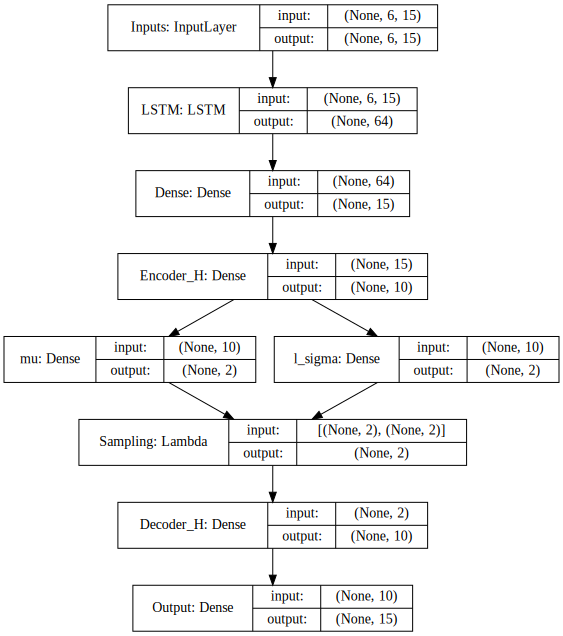

In [28]:
hidden = 64
uncertainty = 2
batch_size = 20

inputs = Input(shape=(window_size, original_dim), name='Inputs')

# inputs_masked = Masking(mask_value=0., name='Masking')(inputs)
encoded = LSTM(hidden, name='LSTM', activation='elu')(inputs)
lstm_output = Dense(original_dim, name='Dense', activation='linear')(encoded)

def sample_z(args):
        mu, l_sigma = args
        eps = K.random_normal(shape=(m, n_z), mean=0., stddev=1.)
        return mu + K.exp(l_sigma / 2) * eps
    
def z_upper(args):
    mu, l_sigma = args
    return mu + uncertainty*K.exp(l_sigma)

def z_lower(args):
    mu, l_sigma = args
    return mu - uncertainty*K.exp(l_sigma)

m = batch_size # batch size
n_z = latent_dim # latent space size
encoder_dim1 = intermediate_dim # dim of encoder hidden layer
decoder_dim = intermediate_dim # dim of decoder hidden layer
decoder_out_dim = original_dim # dim of decoder output layer
n_x = original_dim

# Encoder
encoder_h = Dense(encoder_dim1, activation='relu',  name='Encoder_H')(lstm_output)
mu = Dense(n_z, activation='linear', name='mu')(encoder_h)
l_sigma = Dense(n_z, activation='linear', name='l_sigma')(encoder_h)

# Sampling
z = Lambda(sample_z, output_shape = (n_z, ), name='Sampling')([mu, l_sigma])
z_up = Lambda(z_upper, output_shape = (n_z, ), name='Z_Upper')([mu, l_sigma])
z_low = Lambda(z_lower, output_shape = (n_z, ), name='Z_Lower')([mu, l_sigma])

# Decoding Mean +/- 1 STD
decoder_hidden = Dense(decoder_dim, activation='relu', name='Decoder_H')
decoder_out = Dense(decoder_out_dim, activation='sigmoid', name='Output')

h_p = decoder_hidden(z)
output = decoder_out(h_p)

output_up = decoder_out(decoder_hidden(z_up))
output_low = decoder_out(decoder_hidden(z_low))

def rnn_vae_loss(y_true, y_pred):
        recon = objectives.binary_crossentropy(output, lstm_output)
        pred = objectives.binary_crossentropy(y_pred, y_true)
        kl = 0.5 * K.sum(K.exp(l_sigma) + K.square(mu) - 1. - l_sigma, axis=1)
        return recon + kl + pred

def pred_loss(y_true, y_pred):
    return objectives.binary_crossentropy(y_pred, y_true)

def vae_loss(y_true, y_pred):
    recon = objectives.binary_crossentropy(output, lstm_output)
    kl = 0.5 * K.sum(K.exp(l_sigma) + K.square(mu) - 1. - l_sigma, axis=1)
    return recon + kl

rnn_encoder = Model(inputs, lstm_output)
rnnvae_encoder = Model(inputs, mu)

rnnvae_model = Model(inputs, output)
rnnvae_model_upper = Model(inputs, output_up)
rnnvae_model_lower = Model(inputs, output_low)

rnnvae_model.compile(loss=rnn_vae_loss, metrics=[vae_loss, pred_loss], optimizer=Adam(lr=0.005))
print(rnnvae_model.summary())
SVG(model_to_dot(rnnvae_model, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

In [29]:
rnnvae_model_hist= rnnvae_model.fit(
    data_['x_train_c'], 
    data_['y_train_c'], 
    verbose=0, 
    epochs=1000, 
    batch_size=batch_size, 
    validation_data=(data_['x_test_c'], data_['y_test_c']), 
    callbacks=[EarlyStopping(patience=5),
               TQDMNotebookCallback(metric_format="{name}: {value:0.4f}",leave_outer=True,leave_inner=True)])

In [40]:
rnn_z_encoded = rnnvae_encoder.predict(data_['x_test_c'], batch_size=20)
y_pred = rnnvae_model.predict(data_['x_test_c'], batch_size=20)
rnn_vae_encoded = vae.predict(y_pred, batch_size=20)
y_pred_colors = convert_to_rgb(np.einsum('ij,jk->ik', y_pred, data_['cmap']))
# check if distance from z_upper to z_mean  > z_true to z_mean
print(rnn_z_encoded.shape)
print(y_pred.shape)

(3640, 2)
(3640, 15)


In [41]:
# y_pred_colors = convert_to_rgb(np.einsum('ij,jk->ik', y_pred, data_['cmap']))
x = rnn_vae_encoded[:,0]
y = rnn_vae_encoded[:,1]
t = ['<br>'.join(json.dumps(x).split(',')) for x in data_['y_test_labels']]

trace1 = go.Scatter(
    x=x,
    y=y, 
    mode='markers',
    marker=dict(color = y_pred_colors, opacity=0.8),
    text = t
)
data = [trace1]
layout = go.Layout(margin=dict(l=0,r=0,b=0,t=0))
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='VAE-Data')

In [37]:
# y_pred_colors = convert_to_rgb(np.einsum('ij,jk->ik', y_pred, data_['cmap']))
x = rnn_z_encoded[:,0]
y = rnn_z_encoded[:,1]
t = ['<br>'.join(json.dumps(x).split(',')) for x in data_['y_test_labels']]

trace1 = go.Scatter(
    x=x,
    y=y, 
    mode='markers',
    marker=dict(color = y_pred_colors, opacity=0.8),
    text = t
)
data = [trace1]
layout = go.Layout(margin=dict(l=0,r=0,b=0,t=0))
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='VAE-Data')

# Pre-Train LSTM VAE, MLP VAE, then End-To-End LSTM-VAE

# Convert all data to Z using VAE, Train LSTM, Decode

### Compare all above on prediction-in-std-range metric while training on MSE loss

In [ ]:
1 - show loss for latent=2/3/4/5 (show VAE loss)
2 - show graph of prediction vs timesteps
3 - Justify why VAE is normal
4 - concrete number on how predictable I am
5 - show accuracy vs data size